In [1]:
import ipywidgets as widgets

## Kmeans

(427, 640, 3)

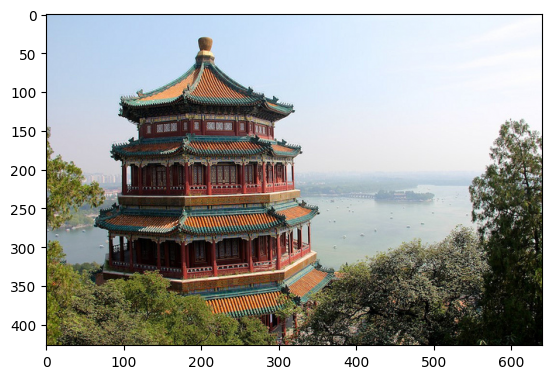

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 5

# Load the Summer Palace photo
origin = load_sample_image('china.jpg')
origin = np.array(origin, dtype=np.float64) / 255
w, h, d = original_shape = tuple(origin.shape)
image_array = np.reshape(origin, (w * h, d))

fi, axes = plt.subplots(1, 1)
axes.imshow(origin)
origin.shape

In [4]:
widgets.ColorPicker(
    concise=False,
    description='Pixel Color',
    value='blue',
    disabled=False
)

ColorPicker(value='blue', description='Pixel Color')

(-0.5, 4.5, 0.5, -0.5)

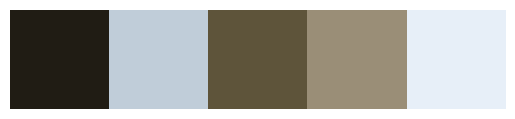

In [7]:
kmeans = KMeans(n_clusters=n_colors, n_init=10, random_state=0)
kmeans.fit(image_array)

fi, axes = plt.subplots(1, 1)
axes.imshow([kmeans.cluster_centers_])
axes.axis('off')

Predicting color indices on the full image (k-means)


(-0.5, 639.5, 426.5, -0.5)

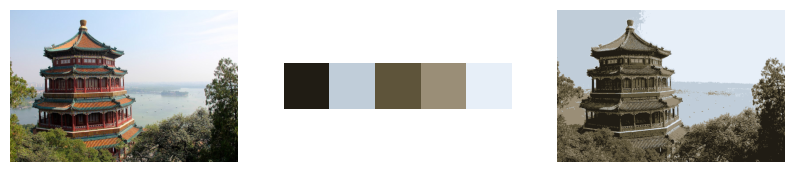

In [6]:
# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

predicted = recreate_image(kmeans.cluster_centers_, labels, w, h)

# Display all results, alongside original image
fi, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].imshow(origin)
axes[0].axis('off')
axes[1].imshow([kmeans.cluster_centers_] )
axes[1].axis('off')
axes[2].imshow(predicted)
axes[2].axis('off')

# EEG

In [11]:
from mne.io import read_raw_eeglab

from pycrostates.cluster import ModKMeans
from pycrostates.datasets import lemon

# load sample dataset
raw_fname = lemon.data_path(subject_id='010017', condition='EC')
raw = read_raw_eeglab(raw_fname, preload=True)
raw.crop(0, 10)  # crop the dataset to speed up computation
raw.pick('eeg')  # select EEG channels
raw.set_eeg_reference('average')  # Apply a common average reference
raw.plot()

Reading C:\Users\ferat\pycrostates_data\PREPROCESSED_LEMON\sub-010017_EC.fdt
Reading 0 ... 119451  =      0.000 ...   477.804 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ferat\AppData\Local\Temp\ipykernel_22040\3264535071.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_eeglab(raw_fname, preload=True)
C:\Users\ferat\AppData\Local\Temp\ipykernel_22040\3264535071.py:8: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(raw_fname, preload=True)


<IPython.core.display.Javascript object>


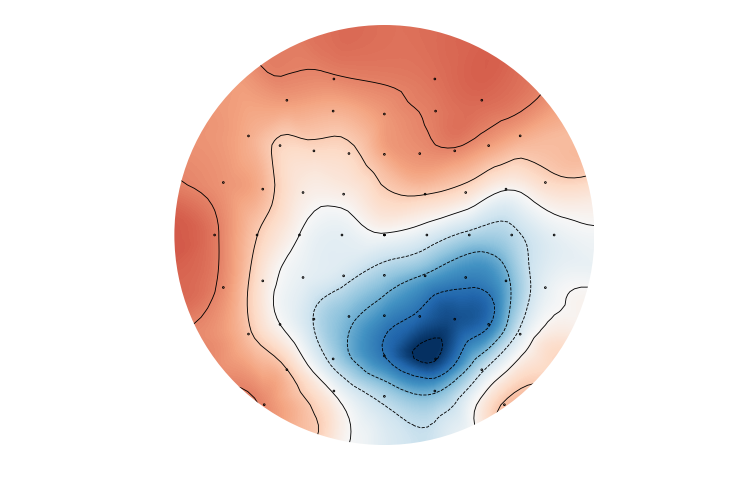

interactive(children=(IntSlider(value=1250, description='t', max=2501), Output()), _dom_classes=('widget-inter…

In [10]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib notebook
import mne
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))
 
data = raw.get_data()
@widgets.interact(t=(0, raw.n_times))
def update(t):
    """Remove old lines from plot and plot new one"""
    ax.clear()
    mne.viz.plot_topomap(data[:,t], raw.info, axes=ax)

In [12]:
n_clusters = 5
ModK = ModKMeans(n_clusters=n_clusters, random_state=42)

After creating a :class:`~pycrostates.cluster.ModKMeans`, the next step is to
fit the model. In other words, fitting a clustering algorithm will determine
the microstate maps, also called :term:`cluster centers`. A clustering
algorithm can be fitted with :class:`~mne.io.Raw`,
:class:`~mne.epochs.Epochs` or :class:`~pycrostates.io.ChData` objects.

<div class="alert alert-info"><h4>Note</h4><p>Fitting a clustering algorithm is a computationaly expensive operation.
    Depending on your configuration, you can change the argument ``n_jobs``
    to take advantage of multiprocessing to reduce computation time.</p></div>



In [13]:
ModK.fit(raw, n_jobs=5)

  0%|          |  : 0/100 [00:00<?,       ?it/s]

[kmeans.fit] INFO: Selecting run with highest GEV = 67.68% after 100/100 iterations converged.


Now that our algorithm is fitted, we can visualize the
:term:`cluster centers`, also called microstate maps or microstate
topographies using :meth:`pycrostates.cluster.ModKMeans.plot`.



<IPython.core.display.Javascript object>


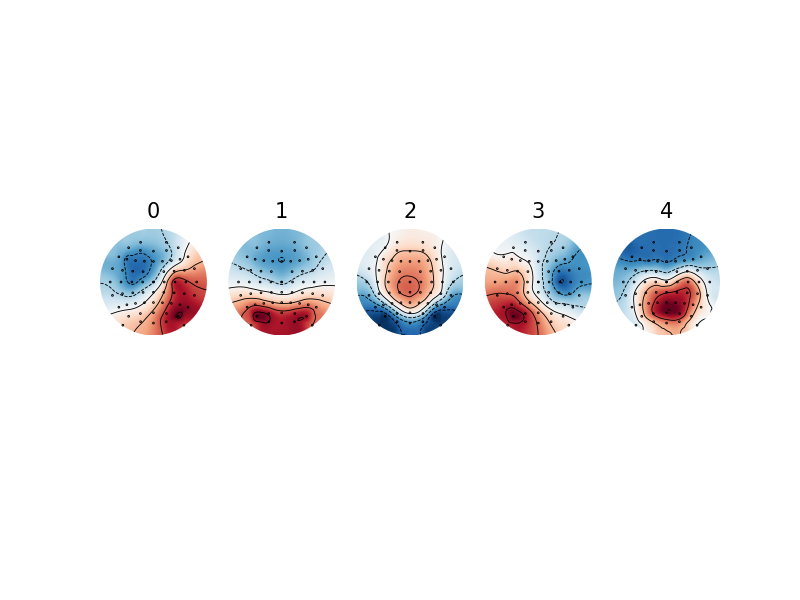

In [14]:
ModK.plot();

The :term:`cluster centers` can be retrieved as a numpy array with the
``cluster_centers_`` attribute.



By default, the :term:`cluster centers` are named from ``0`` to
``n_clusters - 1`` and are ordered based on the fit. You can reorder
(:meth:`pycrostates.cluster.ModKMeans.reorder_clusters`) and
rename (:meth:`pycrostates.cluster.ModKMeans.rename_clusters`) each
microstates to match your preference.



<IPython.core.display.Javascript object>


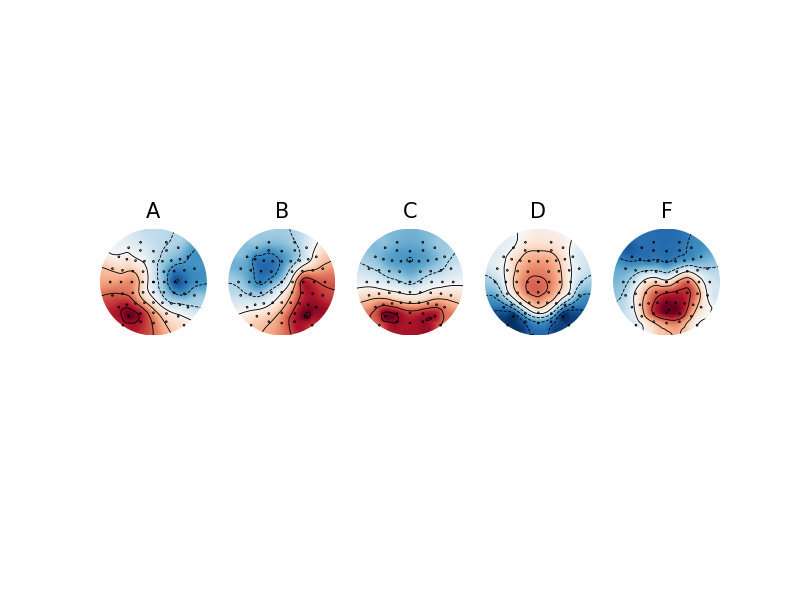

In [15]:
ModK.reorder_clusters(order=[3, 0, 1, 2, 4])
ModK.rename_clusters(new_names=['A', 'B', 'C', 'D', 'F'])
ModK.plot();

### Predict

In [26]:
segmentation = ModK.predict(
    raw,
    reject_by_annotation=True,
    factor=10,
    half_window_size=10,
    min_segment_length=5,
    reject_edges=False,
)

[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0840 (ms).
[_base.predict] INFO: Rejecting segments shorter than 0.0200 (ms).


In [18]:
segmentation._labels.shape

(2501,)

<IPython.core.display.Javascript object>


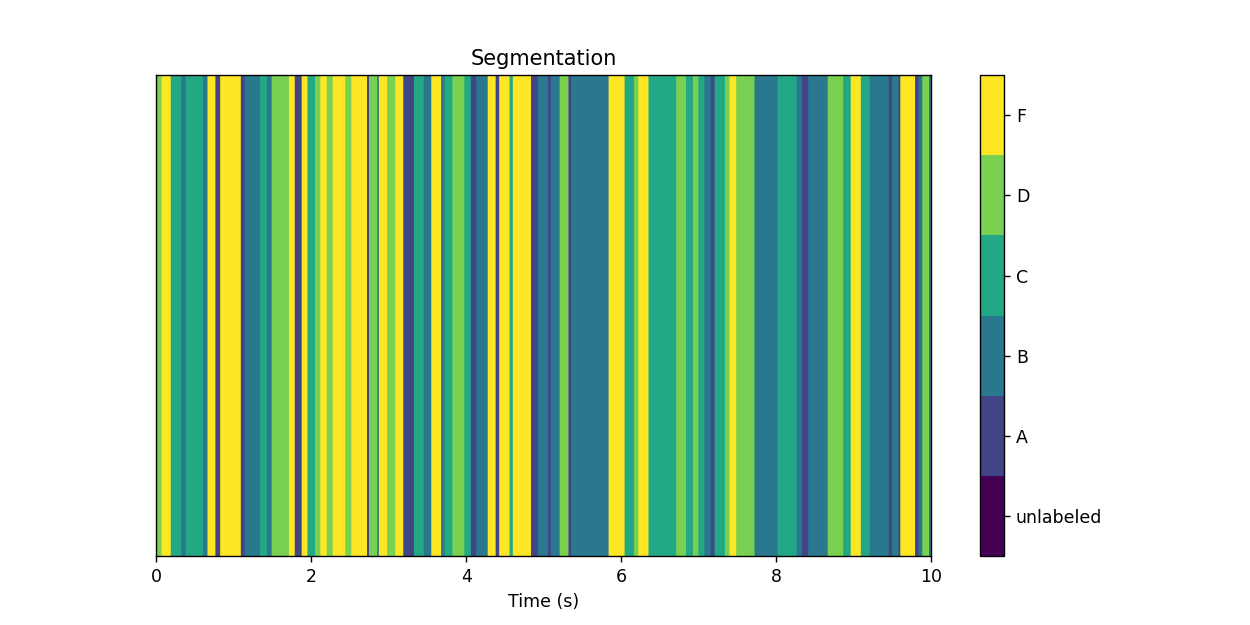

[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last segment is 1 sample long, it does not appear.


[]

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))
segmentation.plot(axes=axes);
axes.set_ylim(0, 1e-6)
axes.get_yaxis().set_ticks([])

### Reject by annotations

[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0840 (ms).
[_base.predict] INFO: Rejecting segments shorter than 0.0200 (ms).


<IPython.core.display.Javascript object>


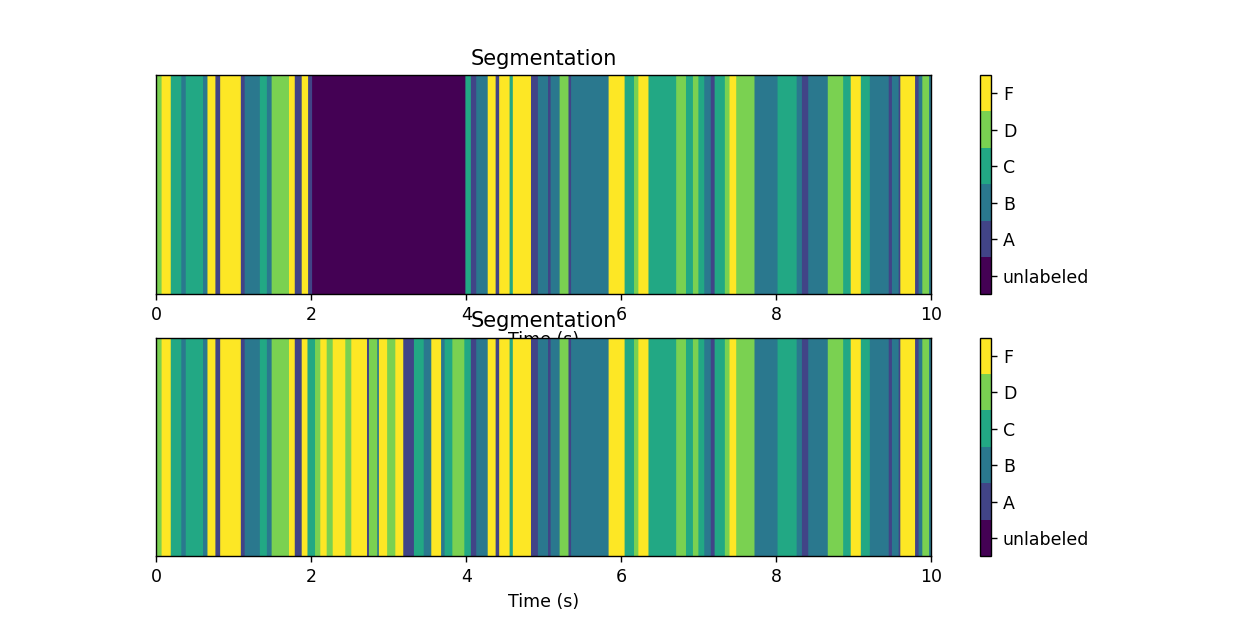

[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last segment is 1 sample long, it does not appear.
[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last segment is 1 sample long, it does not appear.


[]

In [20]:
raw_ = raw.copy()
annotation = mne.Annotations(2, 2, 'bad')
raw_.set_annotations(annotation)
seg = ModK.predict(
    raw_,
    reject_by_annotation=True,
    factor=10,
    half_window_size=10,
    min_segment_length=5,
    reject_edges=False,
)

fig, axes = plt.subplots(2, 1, figsize=(10,5))
seg.plot(axes=axes[0]);
axes[0].set_ylim(0, 1e-6)
axes[0].get_yaxis().set_ticks([])

segmentation.plot(axes=axes[1]);
axes[1].set_ylim(0, 1e-6)
axes[1].get_yaxis().set_ticks([])

### Smoothing

The map polarities can be inverted using the
:meth:`pycrostates.cluster.ModKMeans.invert_polarity`.
method. Note that it only affects visualization, it has not effect during
backfitting as polarities are ignored.



In [21]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img =  predicted
kernel = np.ones((10,10),np.float32)/10**2
dst = cv.filter2D(img,-1,kernel)

# Display all results, alongside original image
fi, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].imshow(origin)
axes[0].axis('off')
axes[1].imshow(predicted)
axes[1].axis('off')
axes[2].imshow(dst)
axes[2].axis('off')

ImportError: DLL load failed while importing cv2: The specified module could not be found.

#### half_window_sizes

<IPython.core.display.Javascript object>


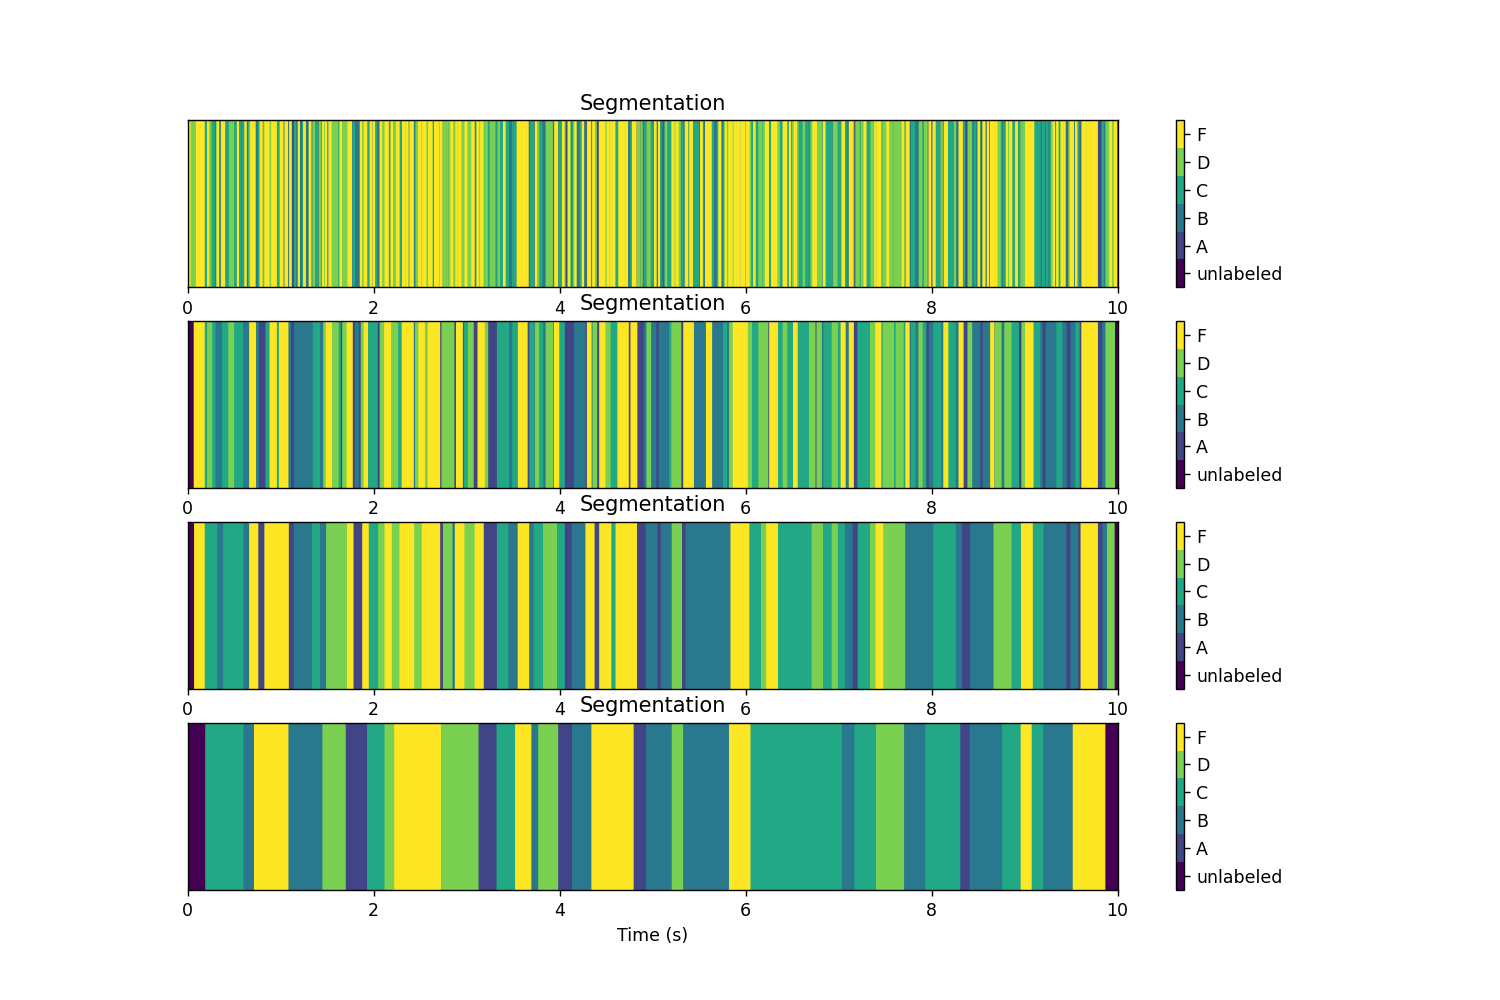

[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0040 (ms).
[_base.predict] INFO: Rejecting first and last segments.
[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last segment is 1 sample long, it does not appear.
[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0440 (ms).
[_base.predict] INFO: Rejecting first and last segments.
[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last segment is 1 sample long, it does not appear.
[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0840 (ms).
[_base.predict] INFO: Rejecting first and last segments.
[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last

In [22]:
half_window_sizes = [0, 5, 10, 20]

fig, axes = plt.subplots(len(half_window_sizes), 1, figsize=(12,8))
for h, half_window_size in enumerate(half_window_sizes):
    ax = axes[h]
    segmentation = ModK.predict(
        raw,
        reject_by_annotation=True,
        factor=10,
        half_window_size=half_window_size)
    segmentation.plot(axes=ax)
    ax.set_ylim(0, 1e-6)
    ax.get_yaxis().set_ticks([])

### min_segment_length

<IPython.core.display.Javascript object>


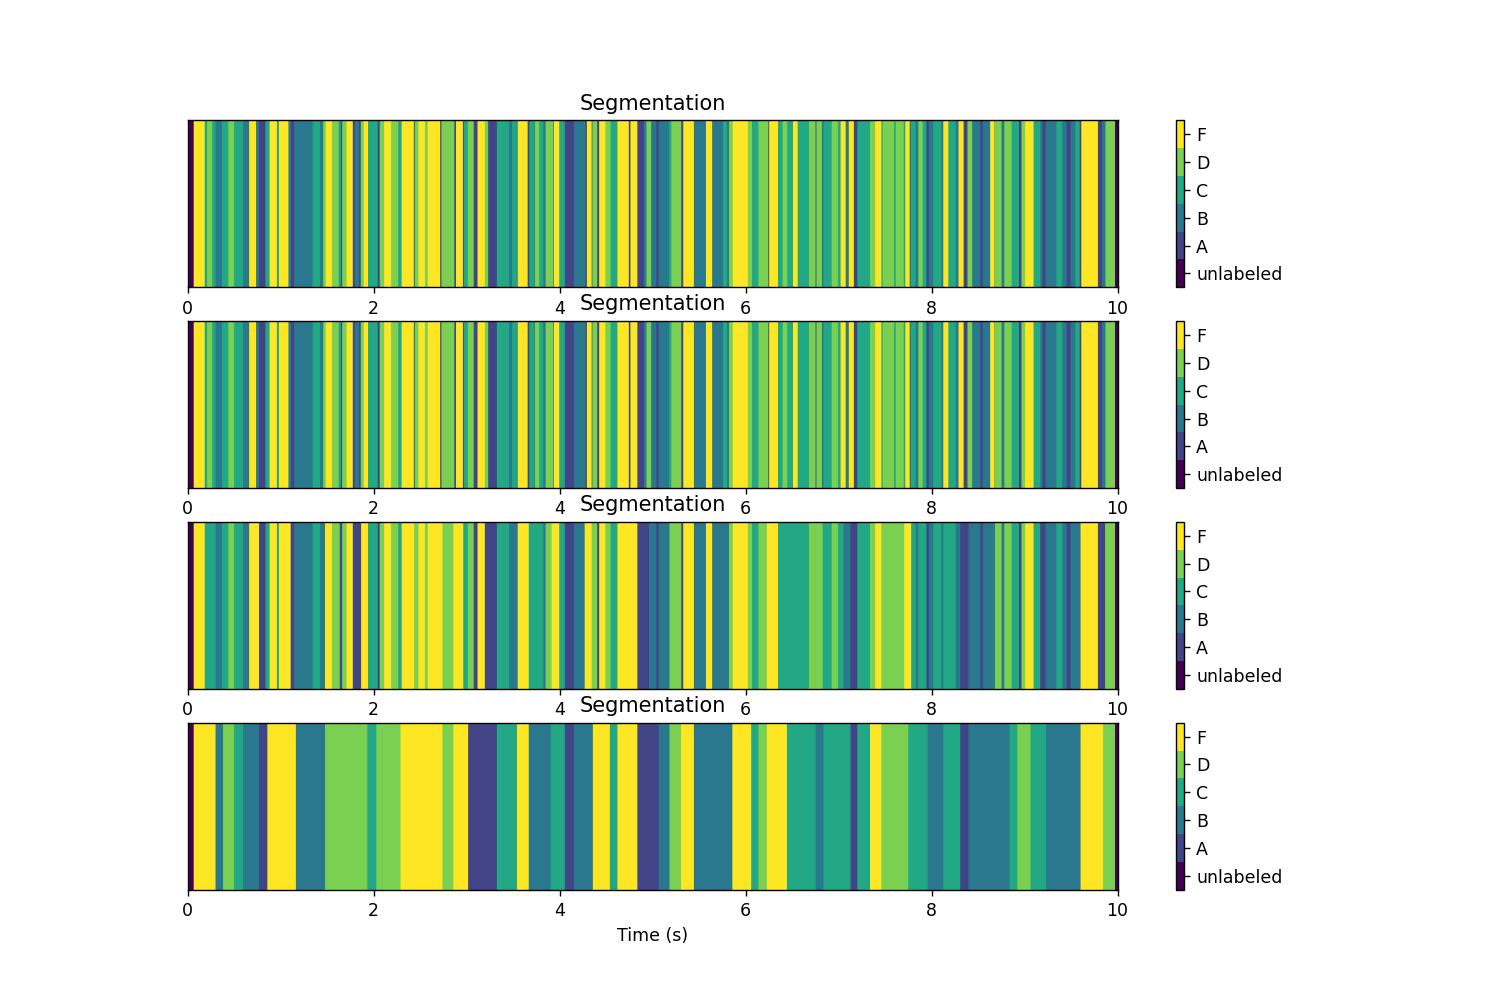

[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0440 (ms).
[_base.predict] INFO: Rejecting first and last segments.
[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last segment is 1 sample long, it does not appear.
[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0440 (ms).
[_base.predict] INFO: Rejecting segments shorter than 0.0200 (ms).
[_base.predict] INFO: Rejecting first and last segments.
[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last segment is 1 sample long, it does not appear.
[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0440 (ms).
[_base.predict] INFO: Rejecting segments shorter than 0.0400 (ms).
[_base.predict] INFO: Rejecting first and last segments.
[segment

In [24]:
min_segment_lengths = [0, 5, 10, 20]

fig, axes = plt.subplots(len(min_segment_lengths), 1, figsize=(12,8))
for h, min_segment_length in enumerate(min_segment_lengths):
    ax = axes[h]
    segmentation = ModK.predict(
        raw,
        reject_by_annotation=True,
        factor=10,
        min_segment_length=min_segment_length,
        half_window_size=5)
    
    segmentation.plot(axes=ax)
    ax.set_ylim(0, 1e-6)
    ax.get_yaxis().set_ticks([])
    

## Results

In [27]:
parameters = segmentation.compute_parameters()
parameters

{'A_mean_corr': 0.5217578194007321,
 'A_gev': 0.03494633348755327,
 'A_occurrences': 1.4994002399040385,
 'A_timecov': 0.1211515393842463,
 'A_meandurs': 0.08080000000000001,
 'B_mean_corr': 0.5795801378080182,
 'B_gev': 0.12354535981139736,
 'B_occurrences': 1.8992403038784487,
 'B_timecov': 0.26509396241503397,
 'B_meandurs': 0.13957894736842105,
 'C_mean_corr': 0.6975277021949904,
 'C_gev': 0.1985878361359408,
 'C_occurrences': 1.599360255897641,
 'C_timecov': 0.2179128348660536,
 'C_meandurs': 0.13625,
 'D_mean_corr': 0.5661609709022127,
 'D_gev': 0.0827093582829083,
 'D_occurrences': 1.599360255897641,
 'D_timecov': 0.17512994802079168,
 'D_meandurs': 0.1095,
 'F_mean_corr': 0.5540342673998319,
 'F_gev': 0.09814233267070946,
 'F_occurrences': 1.8992403038784487,
 'F_timecov': 0.22071171531387446,
 'F_meandurs': 0.11621052631578949,
 'unlabeled': 0.0}

<IPython.core.display.Javascript object>


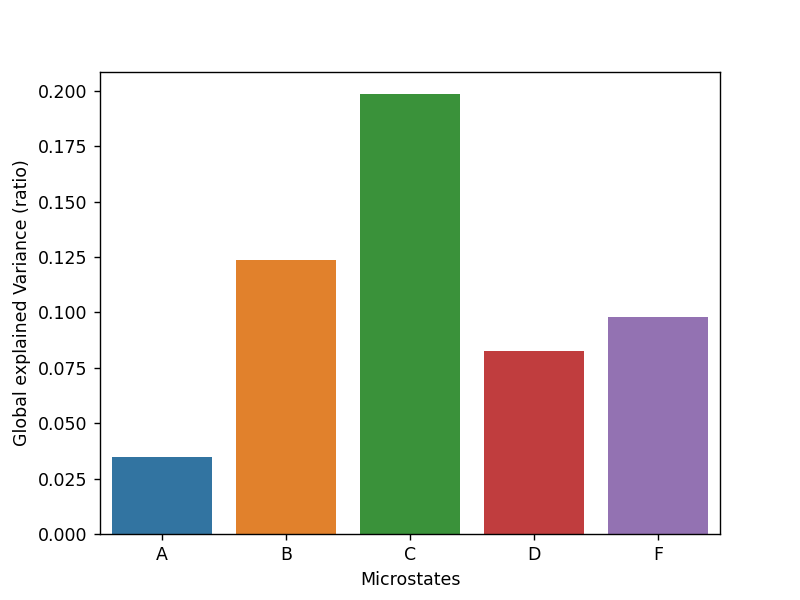

In [28]:
import seaborn as sns
x = ModK.cluster_names
y = [parameters[elt + "_gev"] for elt in x]

plt.figure()
ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Global explained Variance (ratio)")
plt.show()

<IPython.core.display.Javascript object>


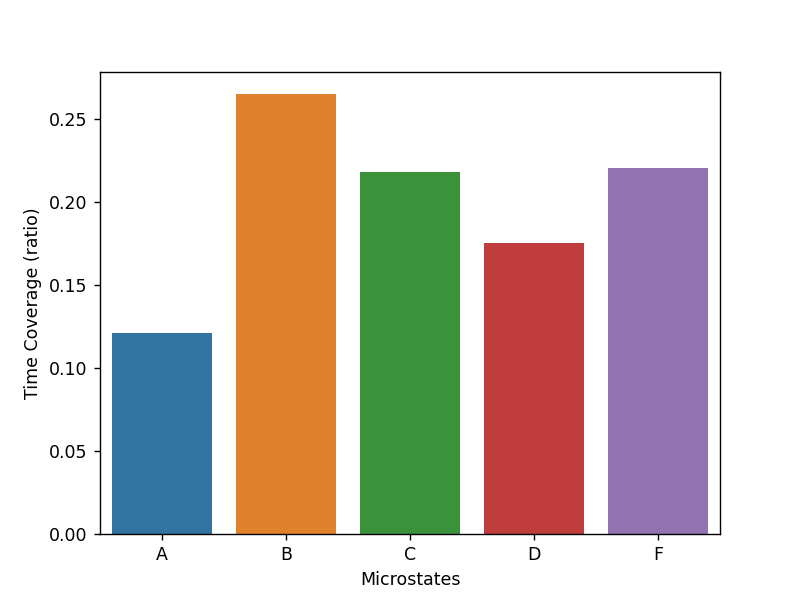

In [29]:
x = ModK.cluster_names
y = [parameters[elt + "_timecov"] for elt in x]

plt.figure()
ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Time Coverage (ratio)")
plt.show()

<IPython.core.display.Javascript object>


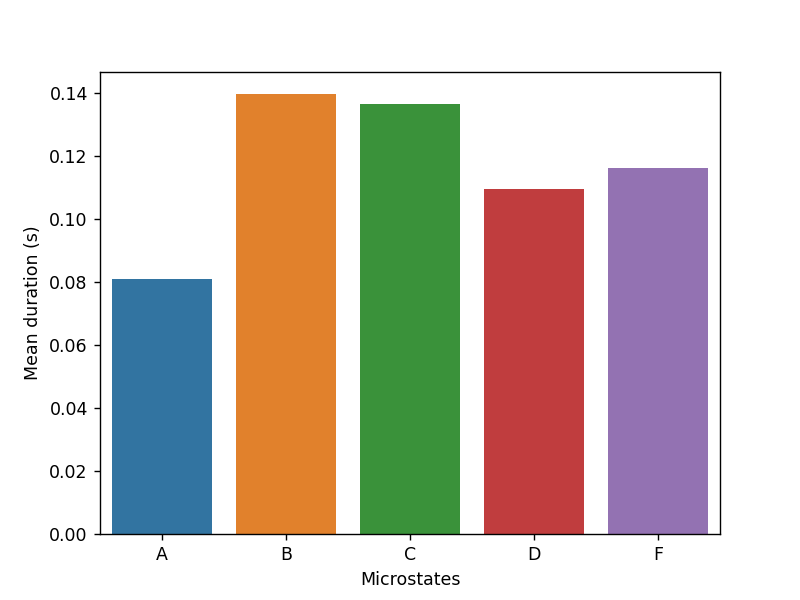

In [30]:
x = ModK.cluster_names
y = [parameters[elt + "_meandurs"] for elt in x]

plt.figure()
ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Mean duration (s)")
plt.show()

## Preprocessing

## GFP peaks 

<IPython.core.display.Javascript object>


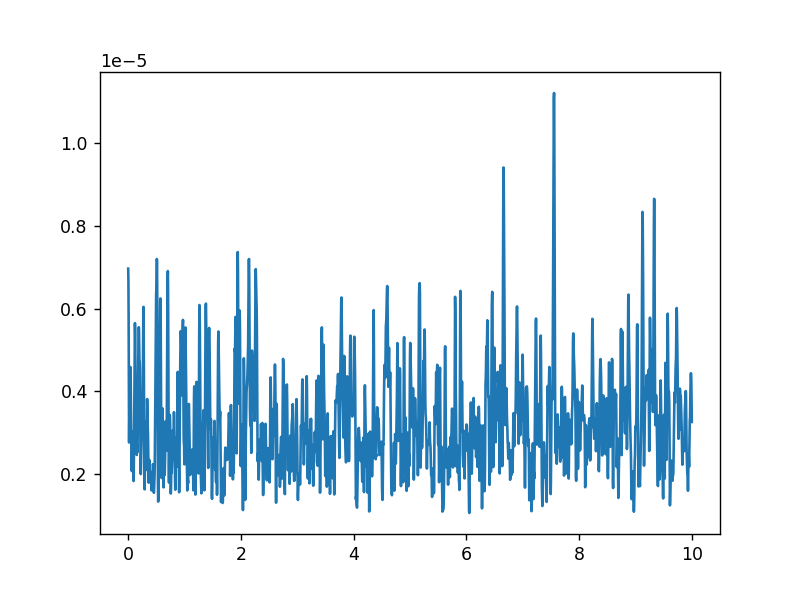

In [31]:
data = raw.get_data()
gfp = np.std(data, axis=0)

plt.figure()
plt.plot(raw.times, gfp)

<IPython.core.display.Javascript object>


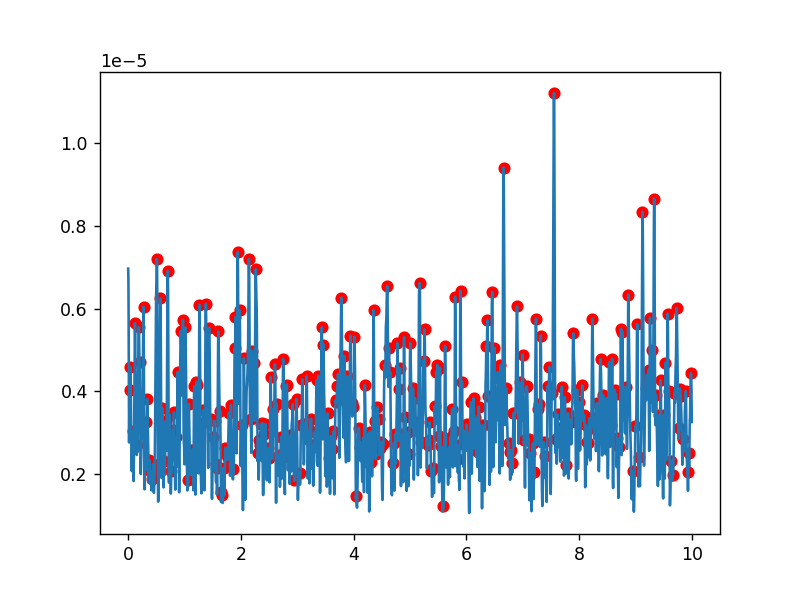

0.1255497800879648

In [32]:
import scipy.signal
ind = scipy.signal.find_peaks(gfp)[0]
plt.figure()
plt.plot(raw.times, gfp)
plt.scatter(raw.times[ind], gfp[ind], color='red')

len(ind)/raw.n_times

In [35]:
from pycrostates.preprocessing import extract_gfp_peaks
gfp_data = extract_gfp_peaks(raw, min_peak_distance=1)
gfp_data

[extract_gfp_peaks.extract_gfp_peaks] INFO: 314 GFP peaks extracted out of 2501 samples (12.55% of the original data).


< ChData | 314 samples >

In [ ]:
n_clusters = 5
ModK = ModKMeans(n_clusters=n_clusters, random_state=42)
ModK.fit(raw, n_jobs=5);
ModK.plot();

ModK = ModKMeans(n_clusters=n_clusters, random_state=42)
ModK.fit(gfp_data, n_jobs=5);
ModK.reorder_clusters(order=[4, 0, 1, 3, 2])
ModK.plot();